In [1]:
import os, random, time, math
from itertools import repeat
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.benchmark = True


# 2.  Building blocks
def _ntuple(n):
    def parse(x):
        return tuple(repeat(x, n)) if not isinstance(x, (list, tuple)) else x
    return parse
to_2tuple = _ntuple(2)


class PatchMerging(nn.Module):
    """
    Swin-style down-sampling.

    Input : (B, N, C)  where N = H × W
    Output: (B, N/4, C_out) with H & W halved.
    """

    def __init__(self, dim_in: int, dim_out: int | None = None):
        super().__init__()
        dim_out = dim_out or dim_in * 2
        self.norm = nn.LayerNorm(4 * dim_in)
        self.reduction = nn.Linear(4 * dim_in, dim_out, bias=False)

    def forward(self, x: torch.Tensor, H: int, W: int) -> torch.Tensor:
        B, L, C = x.shape
        assert L == H * W, "Token length doesn't match H*W"

        x = x.view(B, H, W, C)
        # gather 2 × 2 neighbours
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]

        x = torch.cat([x0, x1, x2, x3], dim=-1)     # (B, H/2, W/2, 4C)
        x = x.view(B, -1, 4 * C)                    # (B, N/4, 4C)
        x = self.norm(x)
        x = self.reduction(x)                       # (B, N/4, C_out)
        return x


class TinyViTBlock(nn.Module):
    """
    **Light** substitute for Swin/TinyViT window attention.
    Keeps tensor shapes identical; swap with real implementation later.
    """

    def __init__(
        self,
        dim: int,
        depth: int = 2,
        num_heads: int = 4,
        mlp_ratio: float = 4.0,
        dropout: float = 0.0,
    ):
        super().__init__()

        layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=num_heads,
            dim_feedforward=int(dim * mlp_ratio),
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation="gelu",
        )
        self.blocks = nn.ModuleList([layer for _ in range(depth)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for blk in self.blocks:
            x = blk(x)
        return x


class ArcMarginProduct(nn.Module):
    """
    ArcFace: additive angular margin.\n
    Reference: https://arxiv.org/abs/1801.07698
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        s: float = 64.0,
        m: float = 0.5,
    ):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.s = s
        self.m = m

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        x = F.normalize(x)
        W = F.normalize(self.weight)
        logits = F.linear(x, W)                     # cosθ
        θ = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        logits = self.s * torch.cos(θ + self.m)     # cos(θ + m)
        return logits


class FaceTinyViT(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int = 512):
        super().__init__()

        # ---- Patch stem ----
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.GELU(),
            nn.Conv2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.GELU()
        )

        # stride-4 patch embedding → 96-d tokens
        self.patch_embed = nn.Conv2d(32, 96, kernel_size=4, stride=4, bias=False)
        self.cls_token   = nn.Parameter(torch.zeros(1, 1, 96))

        # ---- Stage 1 ----
        self.stage1   = TinyViTBlock(dim=96, depth=2, num_heads=3)
        self.down1    = PatchMerging(96, 192)           # 96 → 192
        self.cls_proj1 = nn.Linear(96, 192)             # project CLS

        # ---- Stage 2 ----
        self.stage2   = TinyViTBlock(dim=192, depth=2, num_heads=6)

        # ---- Heads ----
        self.norm         = nn.LayerNorm(192)
        self.head_embed   = nn.Linear(192, emb_dim, bias=False)
        self.arcface      = ArcMarginProduct(emb_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(
        self,
        x: torch.Tensor,
        labels: torch.Tensor | None = None,
        return_embedding: bool = False,
    ):
        # ---- Stem & patch embedding ----
        x = self.stem(x)                 # B, 32, 56, 56   (for 112×112 input)
        B, _, H, W = x.shape
        x = self.patch_embed(x)          # B, 96, 14, 14
        H //= 4; W //= 4

        x = x.flatten(2).transpose(1, 2)  # B, N, 96
        cls = self.cls_token.expand(B, -1, -1)
        x   = torch.cat((cls, x), 1)      # B, 1+N, 96

        # ---- Stage 1 ----
        x = self.stage1(x)
        cls_tok, feat = x[:, :1], x[:, 1:]
        feat = self.down1(feat, H, W)     # B, N/4, 192
        H //= 2; W //= 2
        cls_tok = self.cls_proj1(cls_tok) # B, 1, 192
        x = torch.cat((cls_tok, feat), 1) # B, 1+N/4, 192

        # ---- Stage 2 ----
        x = self.stage2(x)

        # ---- Head ----
        cls_out   = self.norm(x[:, 0])
        embedding = F.normalize(self.head_embed(cls_out), p=2, dim=1)

        if return_embedding or labels is None:
            return embedding

        logits = self.arcface(embedding, labels)
        return logits, embedding


# 4.  Dataset & loaders
DATA_ROOT = Path('/home/pablo/Desktop/reID/face_reID/archive/train')
IMG_SIZE  = 112
MEAN_STD  = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(*MEAN_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.25), value='random'),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(*MEAN_STD),
])

full_ds      = datasets.ImageFolder(DATA_ROOT, transform=train_tfms)
num_classes  = len(full_ds.classes)
val_fraction = 0.1
val_len      = int(len(full_ds) * val_fraction)
train_len    = len(full_ds) - val_len
train_ds, val_ds = random_split(
    full_ds, [train_len, val_len],
    generator=torch.Generator().manual_seed(SEED),
)
val_ds.dataset.transform = val_tfms

BATCH_SIZE = 128
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True,
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True,
)


# 5.  Training utilities
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model    = FaceTinyViT(num_classes=num_classes, emb_dim=512).to(device)

# Load pre-trained weights if available
weights_path = '/home/pablo/Desktop/reID/face_reID/checkpoints/tinyvit_face_best.pth'
if os.path.exists(weights_path):
    print(f"Loading weights from {weights_path}")
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['model_state'] if 'model_state' in checkpoint else checkpoint)
    print("Weights loaded successfully")
else:
    print("No pre-trained weights found, starting from scratch")


Loading weights from /home/pablo/Desktop/reID/face_reID/checkpoints/tinyvit_face_best.pth
Weights loaded successfully


In [66]:
len(os.listdir('/home/pablo/Desktop/reID/face_reID/archive/train'))  # Check number of training images

480

In [11]:
import numpy as np
from PIL import Image


def compute_ids(k):
    # Define the range of folders to process
    start_folder = 100  # Start from n000002
    end_folder = 480  # Process 100 folders

    # Storage for the processed tensors
    identity_tensors = {}

    for folder_id in range(start_folder, end_folder + 1):
        folder_name = f"n{folder_id:06d}"  # Format as n000002, n000003, etc.
        folder_path = DATA_ROOT / folder_name
        
        if not folder_path.exists():
            continue
        
        # Get all image files in the folder
        image_files = list(folder_path.glob('*.jpg')) + list(folder_path.glob('*.png'))
        
        if len(image_files) < 2 * k:
            print(f"Folder {folder_name} has insufficient images ({len(image_files)}), skipping...")
            continue
        
        # Load and transform images to tensors
        tensors = []
        for img_path in image_files[:2*k + 1]:  # Take only first 2*k images
            try:
                img = Image.open(img_path).convert('RGB')
                tensor = val_tfms(img)  # Apply validation transforms
                tensors.append(tensor)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue
        
        if len(tensors) < 2 * k:
            print(f"Folder {folder_name} has insufficient valid images, skipping...")
            continue
        
        # Split into two groups
        first_k = torch.stack(tensors[:k]).to('cuda')  # Shape: (k, 3, 112, 112)
        second_k = torch.stack(tensors[k+1:2*k + 1]).to('cuda')  # Shape: (k, 3, 112, 112)
        
        # Process first_k in batches of 5
        batch_size = 100
        first_embeddings = []
        
        for i in range(0, len(first_k), batch_size):
            batch = first_k[i:i+batch_size]
            with torch.no_grad():
                batch_embeddings = model(batch, return_embedding=True)
            first_embeddings.append(batch_embeddings)
            del batch, batch_embeddings
            torch.cuda.empty_cache()
        
        first_embeddings = torch.cat(first_embeddings, dim=0)
        first_mean = first_embeddings.mean(dim=0)
        del first_k, first_embeddings
        torch.cuda.empty_cache()

        # Process second_k in batches of 5
        second_embeddings = []
        
        for i in range(0, len(second_k), batch_size):
            batch = second_k[i:i+batch_size]
            with torch.no_grad():
                batch_embeddings = model(batch, return_embedding=True)
            second_embeddings.append(batch_embeddings)
            del batch, batch_embeddings
            torch.cuda.empty_cache()
        
        second_embeddings = torch.cat(second_embeddings, dim=0)
        second_mean = second_embeddings.mean(dim=0)
        del second_k, second_embeddings
        torch.cuda.empty_cache()
        
        # Store the results
        identity_tensors[folder_name] = {
            'first_tensor': first_mean,
            'second_tensor': second_mean
        }
    return identity_tensors


In [76]:
import os

# Create the base directory if it doesn't exist
base_dir = '/home/pablo/Desktop/reID/face_reID/identities'
os.makedirs(base_dir, exist_ok=True)

for idx, (person_name, person_data) in enumerate(em.items(), 1):
    # Create folder with numeric name
    person_folder = os.path.join(base_dir, str(idx))
    os.makedirs(person_folder, exist_ok=True)
    
    # Save the two tensors
    first_tensor = person_data['first_tensor']
    second_tensor = person_data['second_tensor']
    
    torch.save(first_tensor, os.path.join(person_folder, 'tensor1.pt'))
    torch.save(second_tensor, os.path.join(person_folder, 'tensor2.pt'))
    
    print(f"Saved tensors for {person_name} in folder {idx}")

print(f"Successfully saved {len(em)} identities in numbered folders")

Saved tensors for n000300 in folder 1
Saved tensors for n000301 in folder 2
Saved tensors for n000302 in folder 3
Saved tensors for n000303 in folder 4
Saved tensors for n000304 in folder 5
Saved tensors for n000305 in folder 6
Saved tensors for n000306 in folder 7
Saved tensors for n000307 in folder 8
Saved tensors for n000308 in folder 9
Saved tensors for n000309 in folder 10
Saved tensors for n000310 in folder 11
Saved tensors for n000311 in folder 12
Saved tensors for n000312 in folder 13
Saved tensors for n000313 in folder 14
Saved tensors for n000314 in folder 15
Saved tensors for n000315 in folder 16
Saved tensors for n000316 in folder 17
Saved tensors for n000317 in folder 18
Saved tensors for n000318 in folder 19
Saved tensors for n000319 in folder 20
Saved tensors for n000320 in folder 21
Saved tensors for n000321 in folder 22
Saved tensors for n000322 in folder 23
Saved tensors for n000323 in folder 24
Saved tensors for n000324 in folder 25
Saved tensors for n000325 in folde

In [ ]:
import torch.nn.functional as F



def compute_acc(k,embs = None):
    # Initialize counters
    if embs == None:
        identity_tensors = compute_ids(k)
    else:
        identity_tensors = embs

    correct_matches = 0
    total_comparisons = 0

    # Get all identity names for easier iteration
    identity_names = list(identity_tensors.keys())

    for i, identity in enumerate(identity_names):
        # Get the two embeddings for current identity
        emb1 = identity_tensors[identity]['first_tensor']
        emb2 = identity_tensors[identity]['second_tensor']
        
        self_similarity = F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
        
        for current_emb in [emb1, emb2]:
            similarities = []
            
            for j, other_identity in enumerate(identity_names):
                if i != j:  # Skip self
                    other_emb1 = identity_tensors[other_identity]['first_tensor']
                    sim = F.cosine_similarity(current_emb.unsqueeze(0), other_emb1.unsqueeze(0)).item()
                    similarities.append(sim)
            
            higher_similarities = sum(1 for sim in similarities if sim > self_similarity)
            
            if higher_similarities == 0:
                correct_matches += 1
            
            total_comparisons += 1

    # Calculate accuracy
    accuracy = correct_matches / total_comparisons if total_comparisons > 0 else 0
    
    return accuracy

In [11]:
compute_acc(1)  # Example usage with k=15 and precomputed embeddings

0.16986301369863013

In [29]:
def evaluate_threshold_accuracy(em, threshold=0.5):
    """
    Evaluate face recognition accuracy using a similarity threshold.
    For each person, compare their self-similarity against all other people.
    If any other person has similarity > threshold, it's considered a false positive.
    """
    correct_predictions = 0
    total_predictions = 0
    
    identity_names = list(em.keys())
    
    for i, person_name in enumerate(identity_names):
        first_emb = em[person_name]['first_tensor']
        second_emb = em[person_name]['second_tensor']
        self_similarity = F.cosine_similarity(first_emb.unsqueeze(0), second_emb.unsqueeze(0)).item()
        
        # Compare with all other people
        is_correctly_identified = True
        
        for j, other_person in enumerate(identity_names):
            if i != j:  # Skip self-comparison
                other_first_emb = em[other_person]['first_tensor']
                
                similarity = F.cosine_similarity(first_emb.unsqueeze(0), other_first_emb.unsqueeze(0)).item()
                
                if similarity > threshold:
                    is_correctly_identified = False
                    break
        
        if self_similarity > threshold and is_correctly_identified:
            correct_predictions += 1
        elif self_similarity <= threshold:
            is_correctly_identified = False
            
        total_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    return accuracy, correct_predictions, total_predictions

# Test different thresholds
thresholds = [0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]
results = []

for threshold in thresholds:
    acc, correct, total = evaluate_threshold_accuracy(em, threshold)
    results.append((threshold, acc, correct, total))
    print(f"Threshold {threshold}: Accuracy = {acc:.4f} ({correct}/{total})")

# Show the variable em for verification
print(f"\nTotal identities in em: {len(em)}")
#Threshold 0.79: Accuracy = 0.8521 (311/365)

Threshold 0.87: Accuracy = 0.9808 (358/365)
Threshold 0.88: Accuracy = 0.9890 (361/365)
Threshold 0.89: Accuracy = 0.9890 (361/365)
Threshold 0.9: Accuracy = 0.9918 (362/365)
Threshold 0.91: Accuracy = 0.9753 (356/365)
Threshold 0.92: Accuracy = 0.9671 (353/365)
Threshold 0.93: Accuracy = 0.9342 (341/365)
Threshold 0.94: Accuracy = 0.8904 (325/365)
Threshold 0.95: Accuracy = 0.8192 (299/365)
Threshold 0.96: Accuracy = 0.6712 (245/365)
Threshold 0.97: Accuracy = 0.4658 (170/365)
Threshold 0.98: Accuracy = 0.1973 (72/365)

Total identities in em: 365


In [24]:
em  = compute_ids(50)

In [36]:
em

{'n000100': {'first_tensor': tensor([-3.5480e-02,  3.4612e-05,  5.4705e-02,  1.9360e-02,  4.0373e-02,
           1.3508e-02, -7.4619e-03, -8.7859e-03, -9.8013e-03,  5.5786e-03,
          -2.6244e-02, -3.2290e-02,  5.7710e-02,  5.0205e-02,  2.2693e-02,
           1.5385e-02, -2.2045e-02, -2.0567e-02,  5.4431e-02, -2.4687e-02,
          -2.0756e-02,  4.5624e-02, -3.9451e-02,  1.0069e-02,  8.4528e-03,
           4.6912e-04,  6.9436e-03, -1.8196e-02,  1.0002e-02, -3.0725e-02,
           5.0686e-02,  3.4485e-02, -3.5401e-02,  1.8369e-03, -2.1160e-03,
          -3.4461e-02, -2.6754e-02,  5.6005e-02, -1.3084e-02, -3.6683e-02,
           1.2986e-02,  3.9414e-02, -3.9058e-02,  2.5354e-02, -2.0038e-02,
           2.7683e-02,  6.8509e-02, -5.5969e-02,  3.8562e-02,  5.7586e-03,
          -3.4692e-02, -2.4725e-02, -2.9231e-03, -8.6131e-03, -1.2013e-02,
          -3.3939e-02, -1.3835e-02, -4.2228e-02,  1.2301e-02, -3.3471e-02,
           7.4187e-02,  6.6137e-02,  8.3366e-03, -2.4964e-02, -1.6878e-02

In [42]:
import numpy as np
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

def compute_tar_at_far(embeddings_dict, far_levels):
    """
    Compute TAR (True Acceptance Rate) at specific FAR (False Acceptance Rate) levels
    """
    # Extract all embeddings and create labels
    genuine_scores = []  # similarities between same person
    impostor_scores = []  # similarities between different people
    
    identity_names = list(embeddings_dict.keys())
    
    for person_name, person_data in embeddings_dict.items():
        first_tensor = person_data['first_tensor']
        second_tensor = person_data['second_tensor']
        
        similarity = F.cosine_similarity(first_tensor.unsqueeze(0), second_tensor.unsqueeze(0)).item()
        genuine_scores.append(similarity)
    
    for i, person1 in enumerate(identity_names):
        first_tensor1 = embeddings_dict[person1]['first_tensor']
        
        for j, person2 in enumerate(identity_names):
            if i < j:  # Avoid duplicate comparisons
                first_tensor2 = embeddings_dict[person2]['first_tensor']
                
                # Similarity between different people
                similarity = F.cosine_similarity(first_tensor1.unsqueeze(0), first_tensor2.unsqueeze(0)).item()
                impostor_scores.append(similarity)
    
    # Create labels: 1 for genuine, 0 for impostor
    y_true = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    y_scores = genuine_scores + impostor_scores
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Compute TAR at specific FAR levels
    tar_at_far = {}
    
    for far_level in far_levels:
        # We want FPR (FAR) <= far_level
        valid_indices = np.where(fpr <= far_level)[0]
        
        if len(valid_indices) > 0:
            best_idx = valid_indices[np.argmax(tpr[valid_indices])]
            tar_at_far[far_level] = tpr[best_idx]
        else:
            tar_at_far[far_level] = 0.0  # No valid threshold found
    
    return tar_at_far, genuine_scores, impostor_scores, fpr, tpr, thresholds

# Define FAR levels from 10^-6 to 10^-2
far_levels = [10**(-i) for i in range(6, 1, -1)]  # [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]


# Store all results in a dictionary
results_dict = {}

for n in [1]+[i*2 for i in range(1, 51)]:
    # Compute TAR at FAR
    em = compute_ids(n)  # Recompute embeddings if needed
    tar_results, genuine_scores, impostor_scores, fpr, tpr, thresholds = compute_tar_at_far(em, far_levels)

    # Store results in dictionary
    results_dict[n] = {
        'tar_at_far': tar_results,
        'genuine_scores': genuine_scores,
        'impostor_scores': impostor_scores,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'num_genuine_pairs': len(genuine_scores),
        'num_impostor_pairs': len(impostor_scores),
        'genuine_mean': np.mean(genuine_scores),
        'genuine_std': np.std(genuine_scores),
        'impostor_mean': np.mean(impostor_scores),
        'impostor_std': np.std(impostor_scores)
    }

    # Print results
    print(f"\nResults for n={n}:")
    print("TAR @ FAR Results:")
    print("-" * 40)
    for far_level, tar_value in tar_results.items():
        print(f"TAR @ FAR {far_level:.0e}: {tar_value:.4f} ({tar_value*100:.2f}%)")

    print(f"\nStatistics:")
    print(f"Number of genuine pairs: {len(genuine_scores)}")
    print(f"Number of impostor pairs: {len(impostor_scores)}")
    print(f"Genuine scores - Mean: {np.mean(genuine_scores):.4f}, Std: {np.std(genuine_scores):.4f}")
    print(f"Impostor scores - Mean: {np.mean(impostor_scores):.4f}, Std: {np.std(impostor_scores):.4f}")


Results for n=1:
TAR @ FAR Results:
----------------------------------------
TAR @ FAR 1e-06: 0.0192 (1.92%)
TAR @ FAR 1e-05: 0.0192 (1.92%)
TAR @ FAR 1e-04: 0.0411 (4.11%)
TAR @ FAR 1e-03: 0.0932 (9.32%)
TAR @ FAR 1e-02: 0.2767 (27.67%)

Statistics:
Number of genuine pairs: 365
Number of impostor pairs: 66430
Genuine scores - Mean: 0.3212, Std: 0.1935
Impostor scores - Mean: 0.1040, Std: 0.1402

Results for n=2:
TAR @ FAR Results:
----------------------------------------
TAR @ FAR 1e-06: 0.0466 (4.66%)
TAR @ FAR 1e-05: 0.0466 (4.66%)
TAR @ FAR 1e-04: 0.1041 (10.41%)
TAR @ FAR 1e-03: 0.2849 (28.49%)
TAR @ FAR 1e-02: 0.5342 (53.42%)

Statistics:
Number of genuine pairs: 365
Number of impostor pairs: 66430
Genuine scores - Mean: 0.5129, Std: 0.1621
Impostor scores - Mean: 0.1434, Std: 0.1408

Results for n=4:
TAR @ FAR Results:
----------------------------------------
TAR @ FAR 1e-06: 0.0740 (7.40%)
TAR @ FAR 1e-05: 0.0740 (7.40%)
TAR @ FAR 1e-04: 0.3151 (31.51%)
TAR @ FAR 1e-03: 0.6274

In [77]:
from scipy.ndimage import gaussian_filter1d

# Extract TAR values for each FAR level
tar2 = [results_dict[i]['tar_at_far'][0.01] for i in results_dict]
tar3 = [results_dict[i]['tar_at_far'][0.001] for i in results_dict]
tar4 = [results_dict[i]['tar_at_far'][0.0001] for i in results_dict]
tar5 = [results_dict[i]['tar_at_far'][1e-05] for i in results_dict]
tar6 = [results_dict[i]['tar_at_far'][1e-06] for i in results_dict]


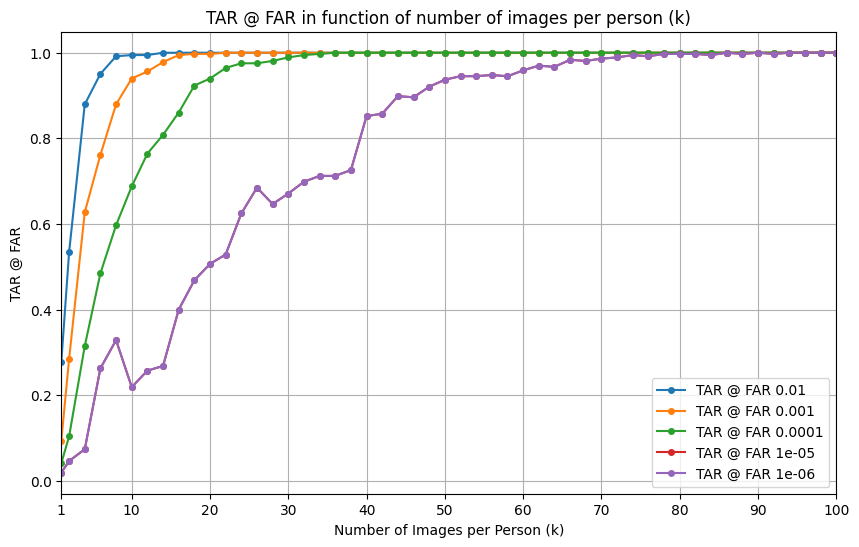

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(list(results_dict.keys()), tar2, marker='o', markersize=4, label='TAR @ FAR 0.01')
plt.plot(list(results_dict.keys()), tar3, marker='o', markersize=4, label='TAR @ FAR 0.001')
plt.plot(list(results_dict.keys()), tar4, marker='o', markersize=4, label='TAR @ FAR 0.0001')
plt.plot(list(results_dict.keys()), tar5, marker='o', markersize=4, label='TAR @ FAR 1e-05')
plt.plot(list(results_dict.keys()), tar6, marker='o', markersize=4, label='TAR @ FAR 1e-06')
plt.title('TAR @ FAR in function of number of images per person (k)')
plt.xlabel('Number of Images per Person (k)')
plt.ylabel('TAR @ FAR')
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlim(1, 100)
plt.grid()
plt.legend()
plt.show()

Computing ROC for k=1...
k=1: AUC = 0.8160, Genuine pairs: 365, Impostor pairs: 66430
Computing ROC for k=2...
k=2: AUC = 0.9547, Genuine pairs: 365, Impostor pairs: 66430
Computing ROC for k=3...
k=3: AUC = 0.9840, Genuine pairs: 365, Impostor pairs: 66430
Computing ROC for k=5...
k=5: AUC = 0.9962, Genuine pairs: 365, Impostor pairs: 66430
Computing ROC for k=10...
k=10: AUC = 0.9997, Genuine pairs: 365, Impostor pairs: 66430
Computing ROC for k=15...
k=15: AUC = 0.9999, Genuine pairs: 365, Impostor pairs: 66430
Computing ROC for k=20...
k=20: AUC = 1.0000, Genuine pairs: 365, Impostor pairs: 66430


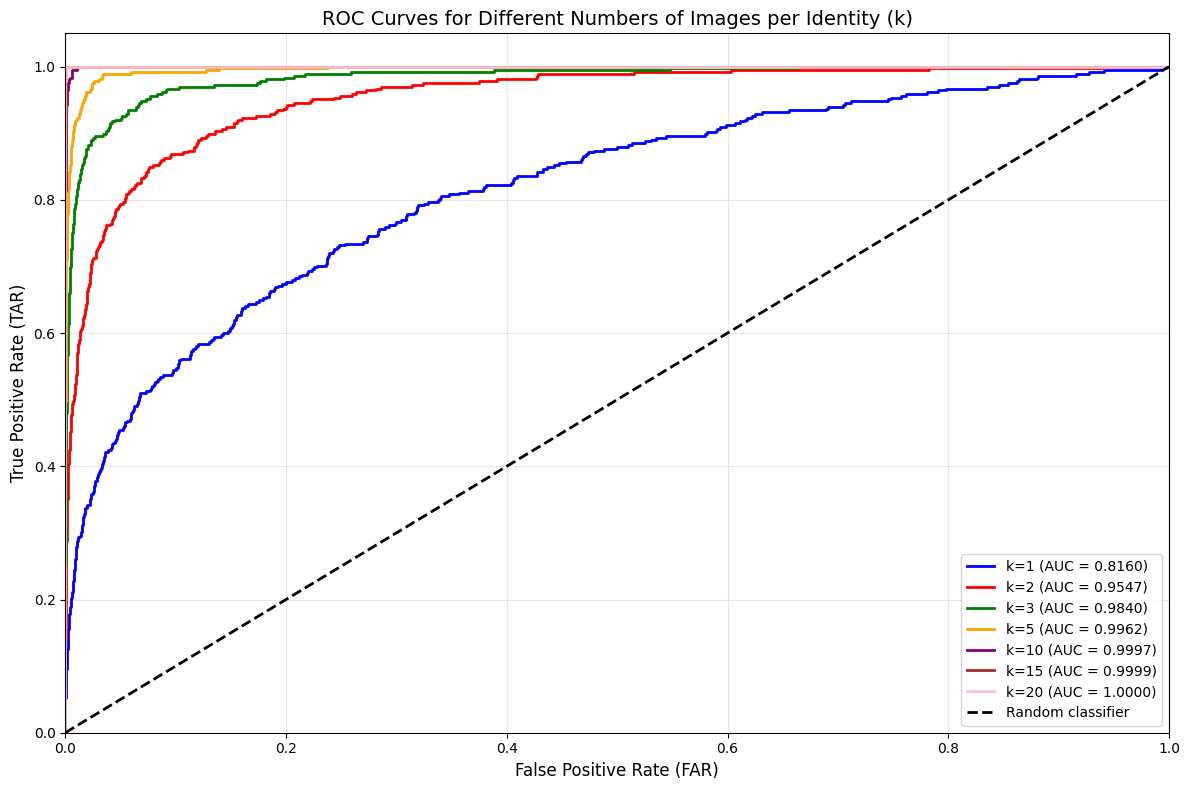

In [84]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Define k values to test
k_values = [1,2,3,5,10,15,20]
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']

plt.figure(figsize=(12, 8))

for i, k in enumerate(k_values):
    print(f"Computing ROC for k={k}...")
    
    # Compute embeddings for current k
    em = compute_ids(k)
    
    # Compute TAR at FAR and get ROC data
    tar_results, genuine_scores, impostor_scores, fpr, tpr, thresholds = compute_tar_at_far(em, far_levels)
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'k={k} (AUC = {roc_auc:.4f})')
    
    print(f"k={k}: AUC = {roc_auc:.4f}, Genuine pairs: {len(genuine_scores)}, Impostor pairs: {len(impostor_scores)}")

# Plot random classifier line
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random classifier')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FAR)', fontsize=12)
plt.ylabel('True Positive Rate (TAR)', fontsize=12)
plt.title('ROC Curves for Different Numbers of Images per Identity (k)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def compute_dir_far(em, k_values=[1, 5, 10], thresholds=None):
    """
    Compute Detection and Identification Rate (DIR) and False Acceptance Rate (FAR)
    
    Args:
        em: Dictionary with identity embeddings {identity_name: {'first_tensor': ..., 'second_tensor': ...}}
        k_values: List of k values for top-k identification
        thresholds: List of threshold values to test
    
    Returns:
        Dictionary with results for each k and threshold
    """
    if thresholds is None:
        thresholds = np.arange(0.5, 1.0, 0.05)
    
    # Split identities into gallery and probe
    identity_names = list(em.keys())
    
    # Use first_tensor as gallery embeddings
    gallery_embeddings = {}
    gallery_identities = []
    
    for identity in identity_names:
        gallery_embeddings[identity] = em[identity]['first_tensor']
        gallery_identities.append(identity)
    
    known_probes = {}
    unknown_probes = {}
    
    num_known = int(0.8 * len(identity_names))
    
    for i, identity in enumerate(identity_names):
        if i < num_known:
            known_probes[identity] = em[identity]['second_tensor']
        else:
            unknown_probes[f"unknown_{identity}"] = em[identity]['second_tensor']
    
    results = {}
    
    for k in k_values:
        results[k] = {}
        
        for tau in thresholds:
            correct_accepted_known = 0
            total_known = len(known_probes)
            accepted_unknown = 0
            total_unknown = len(unknown_probes)
            
            # Process known probes
            for probe_identity, probe_embedding in known_probes.items():
                similarities = []
                for gallery_identity, gallery_embedding in gallery_embeddings.items():
                    sim = F.cosine_similarity(probe_embedding.unsqueeze(0), gallery_embedding.unsqueeze(0)).item()
                    similarities.append((sim, gallery_identity))
                
                # Sort by similarity (descending)
                similarities.sort(key=lambda x: x[0], reverse=True)
                
                # Get max similarity and top-k predictions
                max_similarity = similarities[0][0]
                top_k_identities = [similarities[i][1] for i in range(min(k, len(similarities)))]
                
                # Check if accepted (similarity >= threshold)
                if max_similarity >= tau:
                    # Check if correct identity is in top-k
                    if probe_identity in top_k_identities:
                        correct_accepted_known += 1
            
            # Process unknown probes
            for probe_name, probe_embedding in unknown_probes.items():
                similarities = []
                for gallery_identity, gallery_embedding in gallery_embeddings.items():
                    sim = F.cosine_similarity(probe_embedding.unsqueeze(0), gallery_embedding.unsqueeze(0)).item()
                    similarities.append((sim, gallery_identity))
                
                # Sort by similarity (descending)
                similarities.sort(key=lambda x: x[0], reverse=True)
                max_similarity = similarities[0][0]
                
                # Check if wrongly accepted
                if max_similarity >= tau:
                    accepted_unknown += 1
            
            # Compute metrics
            dir_k = correct_accepted_known / total_known if total_known > 0 else 0
            far = accepted_unknown / total_unknown if total_unknown > 0 else 0
            
            results[k][tau] = {
                'DIR': dir_k,
                'FAR': far,
                'correct_accepted_known': correct_accepted_known,
                'total_known': total_known,
                'accepted_unknown': accepted_unknown,
                'total_unknown': total_unknown
            }
    
    return results

# Test with different k values and thresholds
k_values = [1, 5, 10]
thresholds = np.arange(0, 1.0, 0.1)

# Compute DIR@k and FAR
dir_far_results = compute_dir_far(em, k_values, thresholds)

# Print results for each k
for k in k_values:
    print(f"\n=== Results for k={k} ===")
    print("Threshold\tDIR@{}\tFAR\tCorrect/Total Known\tAccepted/Total Unknown".format(k))
    print("-" * 80)
    
    for tau in sorted(dir_far_results[k].keys()):
        result = dir_far_results[k][tau]
        print(f"{tau:.2f}\t\t{result['DIR']:.4f}\t{result['FAR']:.4f}\t"
              f"{result['correct_accepted_known']}/{result['total_known']}\t\t"
              f"{result['accepted_unknown']}/{result['total_unknown']}")


=== Results for k=1 ===
Threshold	DIR@1	FAR	Correct/Total Known	Accepted/Total Unknown
--------------------------------------------------------------------------------
0.10		1.0000	1.0000	292/292		73/73
0.20		1.0000	1.0000	292/292		73/73
0.30		1.0000	1.0000	292/292		73/73
0.40		1.0000	1.0000	292/292		73/73
0.50		1.0000	1.0000	292/292		73/73
0.60		0.9897	1.0000	289/292		73/73
0.70		0.9281	0.9178	271/292		67/73
0.80		0.7158	0.6712	209/292		49/73
0.90		0.1712	0.1233	50/292		9/73

=== Results for k=5 ===
Threshold	DIR@5	FAR	Correct/Total Known	Accepted/Total Unknown
--------------------------------------------------------------------------------
0.10		1.0000	1.0000	292/292		73/73
0.20		1.0000	1.0000	292/292		73/73
0.30		1.0000	1.0000	292/292		73/73
0.40		1.0000	1.0000	292/292		73/73
0.50		1.0000	1.0000	292/292		73/73
0.60		0.9897	1.0000	289/292		73/73
0.70		0.9281	0.9178	271/292		67/73
0.80		0.7158	0.6712	209/292		49/73
0.90		0.1712	0.1233	50/292		9/73

=== Results for k=10 ===
Threshold	

metrica computata manualemente

In [36]:
impostors

[tensor([-3.5086e-02, -1.0102e-03,  5.7164e-02,  1.9227e-02,  4.0290e-02,
          1.4099e-02, -9.0465e-03, -6.2236e-03, -9.8773e-03,  4.6445e-03,
         -2.7686e-02, -3.1660e-02,  5.6710e-02,  5.0467e-02,  2.2530e-02,
          1.6364e-02, -2.2462e-02, -2.0522e-02,  5.5490e-02, -2.5478e-02,
         -2.1647e-02,  4.5378e-02, -3.9840e-02,  9.6844e-03,  9.6083e-03,
          3.2935e-03,  5.6315e-03, -1.5864e-02,  1.1999e-02, -3.1734e-02,
          5.0815e-02,  3.3604e-02, -3.8533e-02,  3.5727e-03, -3.5604e-03,
         -3.3032e-02, -2.7640e-02,  5.6820e-02, -1.3322e-02, -3.6633e-02,
          1.3045e-02,  3.9692e-02, -4.0088e-02,  2.5409e-02, -2.2953e-02,
          2.9691e-02,  6.8947e-02, -5.5743e-02,  3.7916e-02,  5.7531e-03,
         -3.4882e-02, -2.2959e-02, -2.8661e-03, -8.3887e-03, -1.1996e-02,
         -3.5326e-02, -1.5041e-02, -4.0757e-02,  1.2967e-02, -3.3177e-02,
          7.7439e-02,  6.6814e-02,  8.6412e-03, -2.4686e-02, -1.8537e-02,
         -1.5704e-02, -2.5466e-02, -9.

In [52]:
ALL_EM = {i:compute_ids(i) for i in range(1,50)} 

In [56]:
results = {i:{} for i in ALL_EM}
for k in ALL_EM:
    em = ALL_EM[k]
    results[k] = {t:{} for t in [0.5, 0.6, 0.7, 0.8, 0.9]}  # Initialize results for each threshold
    for th in [0.5, 0.6, 0.7, 0.8, 0.9]:


        keys = list(em.keys())

        impostors, legit = [em[i] for i in keys[:len(keys)//5]], [em[i] for i in keys[len(keys)//5:]]
        impostors = [i['first_tensor'] for i in impostors] + [i['second_tensor'] for i in impostors]
        gallery = [i['first_tensor'] for i in legit]
        legits = [i['second_tensor'] for i in legit]


        #FPIR
        impostor_embeddings = torch.stack(impostors).cpu().numpy()  # Shape: (num_impostors, 512)
        gallery_embeddings = torch.stack(gallery).cpu().numpy()    # Shape: (num_gallery, 512)
        legit_embeddings = torch.stack(legits).cpu().numpy()       # Shape: (num_legits, 512)

        # Normalize embeddings for cosine similarity
        impostor_embeddings = impostor_embeddings / np.linalg.norm(impostor_embeddings, axis=1, keepdims=True)
        gallery_embeddings = gallery_embeddings / np.linalg.norm(gallery_embeddings, axis=1, keepdims=True)
        legit_embeddings = legit_embeddings / np.linalg.norm(legit_embeddings, axis=1, keepdims=True)

        impostor_similarities = np.dot(impostor_embeddings, gallery_embeddings.T)  # Shape: (num_impostors, num_gallery)
        legit_similarities = np.dot(legit_embeddings, gallery_embeddings.T)       # Shape: (num_legits, num_gallery)

        impostor_max_sims = np.max(impostor_similarities, axis=1)
        legit_max_sims = np.max(legit_similarities, axis=1)

        # Count wrong and right classifications
        wrong = np.sum(impostor_max_sims > th)
        right = np.sum(legit_max_sims > th)

        print(f"False Positive Impostor Rate (FPIR) at threshold {th}: {wrong / len(impostors) * 100:.2f}%")
        print(f"True Positive Legit Rate (TPLR) at threshold {th}: {right / len(legits) * 100:.2f}%")

        results[k][th] = {
            'FPIR': wrong / len(impostors),
            'TPLR': right / len(legits)
        }


False Positive Impostor Rate (FPIR) at threshold 0.5: 40.41%
True Positive Legit Rate (TPLR) at threshold 0.5: 42.47%
False Positive Impostor Rate (FPIR) at threshold 0.6: 14.38%
True Positive Legit Rate (TPLR) at threshold 0.6: 14.04%
False Positive Impostor Rate (FPIR) at threshold 0.7: 0.68%
True Positive Legit Rate (TPLR) at threshold 0.7: 3.42%
False Positive Impostor Rate (FPIR) at threshold 0.8: 0.00%
True Positive Legit Rate (TPLR) at threshold 0.8: 0.00%
False Positive Impostor Rate (FPIR) at threshold 0.9: 0.00%
True Positive Legit Rate (TPLR) at threshold 0.9: 0.00%
False Positive Impostor Rate (FPIR) at threshold 0.5: 56.16%
True Positive Legit Rate (TPLR) at threshold 0.5: 68.15%
False Positive Impostor Rate (FPIR) at threshold 0.6: 17.12%
True Positive Legit Rate (TPLR) at threshold 0.6: 40.75%
False Positive Impostor Rate (FPIR) at threshold 0.7: 4.11%
True Positive Legit Rate (TPLR) at threshold 0.7: 15.41%
False Positive Impostor Rate (FPIR) at threshold 0.8: 0.00%
Tru

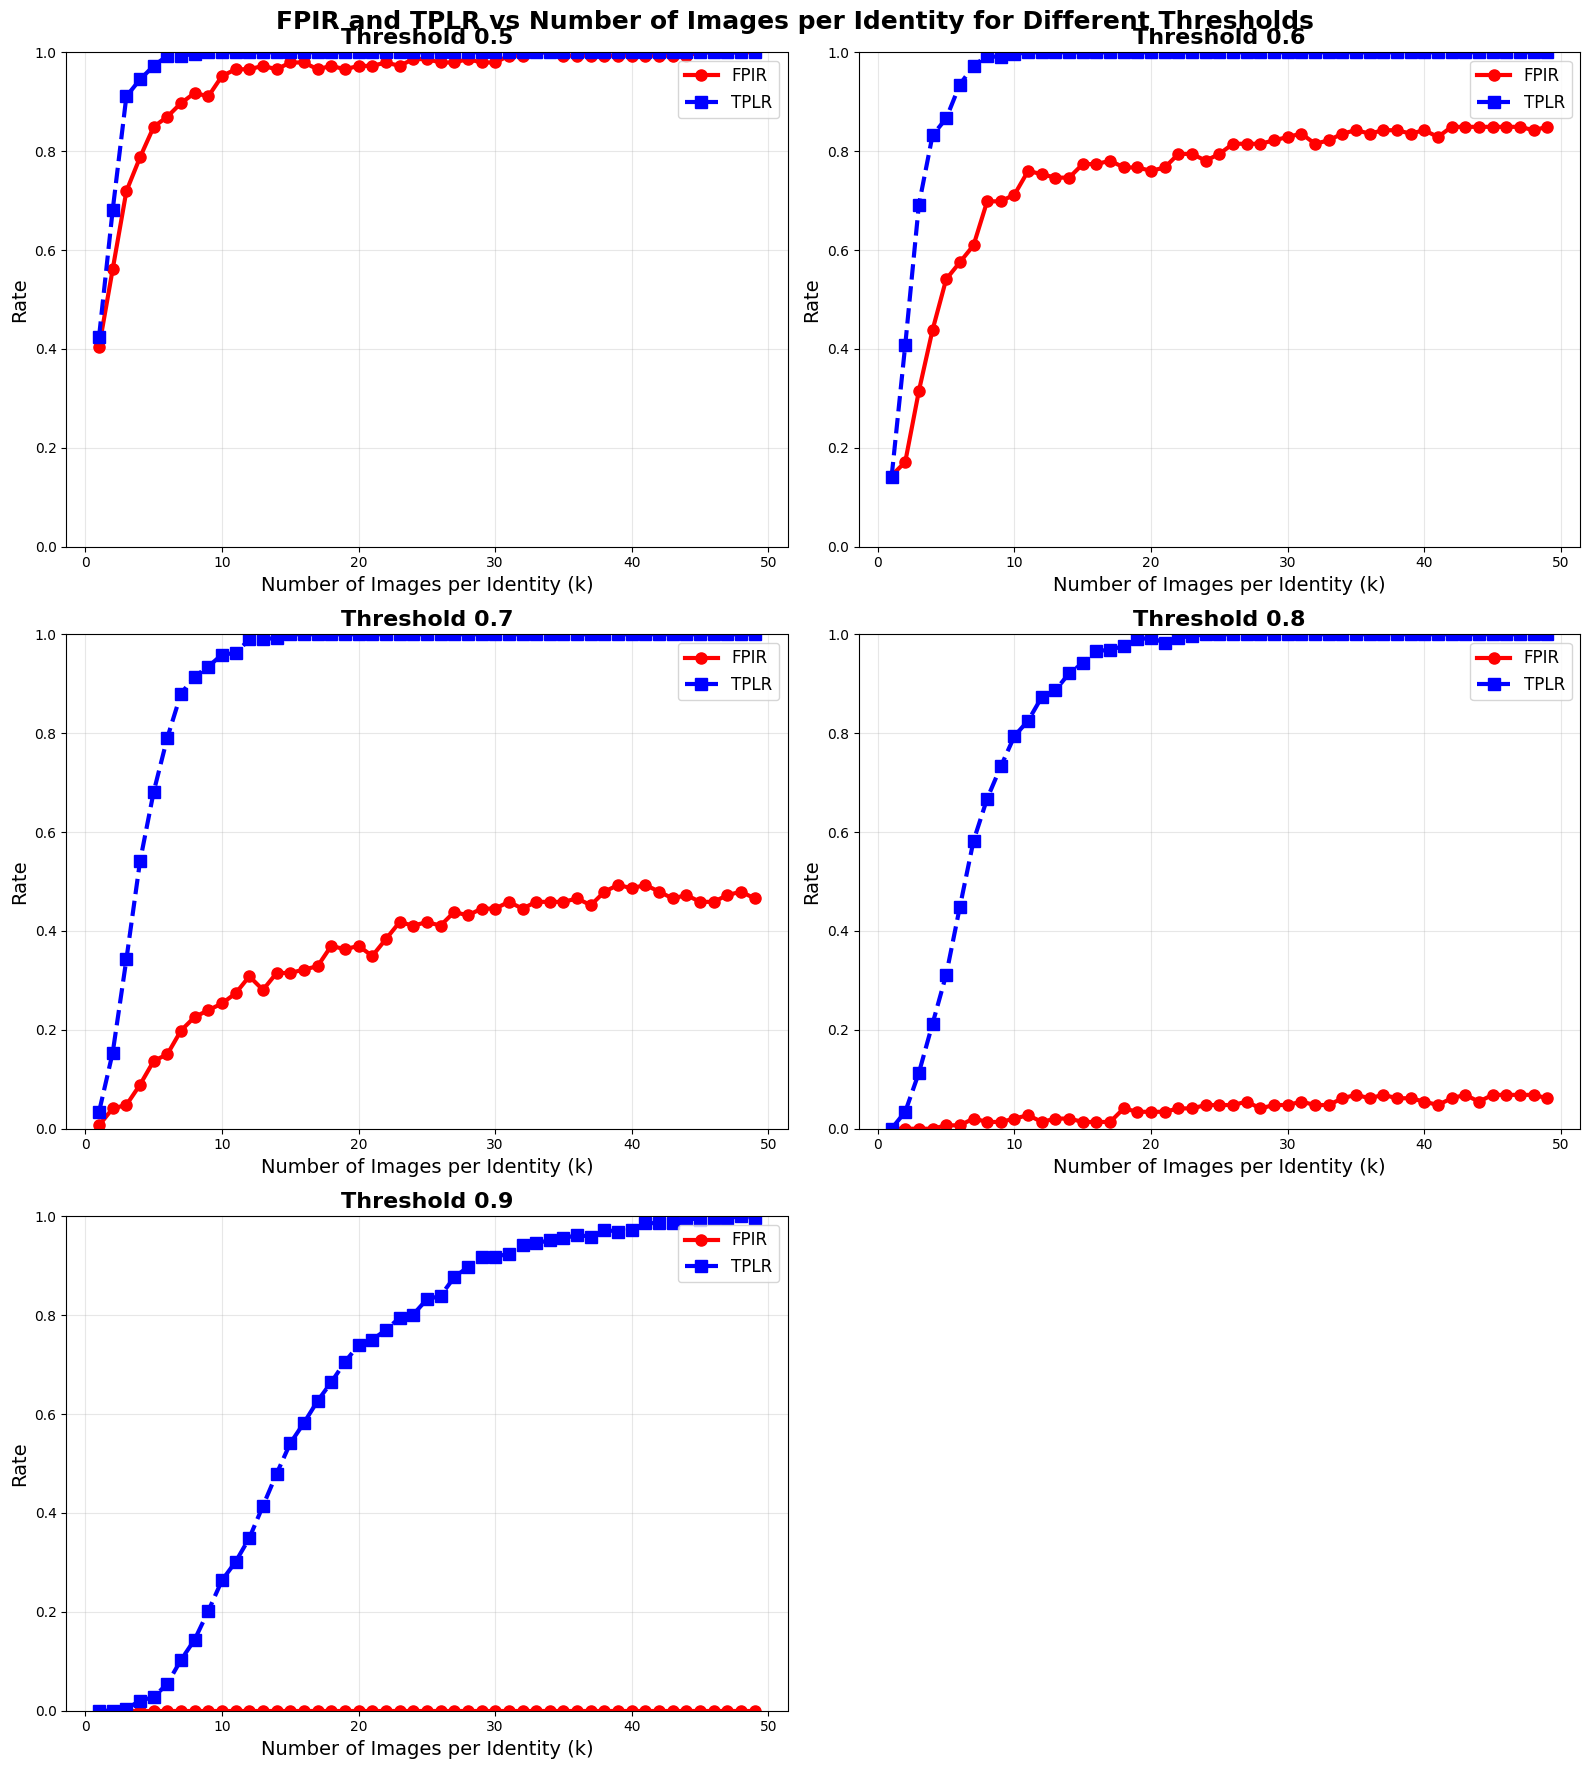

Detailed Statistics by Threshold:

Threshold 0.5:
  FPIR - Min: 0.4041, Max: 1.0000, Mean: 0.9448, Std: 0.1109
  TPLR - Min: 0.4247, Max: 1.0000, Mean: 0.9779, Std: 0.0926

Threshold 0.6:
  FPIR - Min: 0.1438, Max: 0.8493, Mean: 0.7455, Std: 0.1616
  TPLR - Min: 0.1404, Max: 1.0000, Mean: 0.9556, Std: 0.1525

Threshold 0.7:
  FPIR - Min: 0.0068, Max: 0.4932, Mean: 0.3611, Std: 0.1317
  TPLR - Min: 0.0342, Max: 1.0000, Mean: 0.9218, Std: 0.2102

Threshold 0.8:
  FPIR - Min: 0.0000, Max: 0.0685, Mean: 0.0393, Std: 0.0223
  TPLR - Min: 0.0000, Max: 1.0000, Mean: 0.8615, Std: 0.2729

Threshold 0.9:
  FPIR - Min: 0.0000, Max: 0.0000, Mean: 0.0000, Std: 0.0000
  TPLR - Min: 0.0000, Max: 1.0000, Mean: 0.6758, Std: 0.3496


In [ ]:
import matplotlib.pyplot as plt

# Extract data from results dictionary
k_values = sorted(results.keys())
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, threshold in enumerate(thresholds):
    ax = axes[idx]
    
    fpir_values = [results[k][threshold]['FPIR'] for k in k_values]
    tplr_values = [results[k][threshold]['TPLR'] for k in k_values]
    
    # Plot both curves on the same subplot
    ax.plot(k_values, fpir_values, marker='o', linestyle='-', linewidth=3, 
            label='FPIR', color='red', markersize=4)
    ax.plot(k_values, tplr_values, marker='s', linestyle='--', linewidth=3, 
            label='TPLR', color='blue', markersize=4)
    
    ax.set_xlabel('Number of Images per Identity (k)', fontsize=14)
    ax.set_ylabel('Rate', fontsize=14)
    ax.set_title(f'Threshold {threshold}', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    # Add text with statistics
    fpir_mean = np.mean(fpir_values)
    tplr_mean = np.mean(tplr_values)

axes[5].set_visible(False)

plt.suptitle('FPIR and TPLR vs Number of Images per Identity for Different Thresholds', 
             fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed statistics for each threshold
print("Detailed Statistics by Threshold:")
print("=" * 60)
for threshold in thresholds:
    fpir_values = [results[k][threshold]['FPIR'] for k in k_values]
    tplr_values = [results[k][threshold]['TPLR'] for k in k_values]
    
    print(f"\nThreshold {threshold}:")
    print(f"  FPIR - Min: {min(fpir_values):.4f}, Max: {max(fpir_values):.4f}, Mean: {np.mean(fpir_values):.4f}, Std: {np.std(fpir_values):.4f}")
    print(f"  TPLR - Min: {min(tplr_values):.4f}, Max: {max(tplr_values):.4f}, Mean: {np.mean(tplr_values):.4f}, Std: {np.std(tplr_values):.4f}")


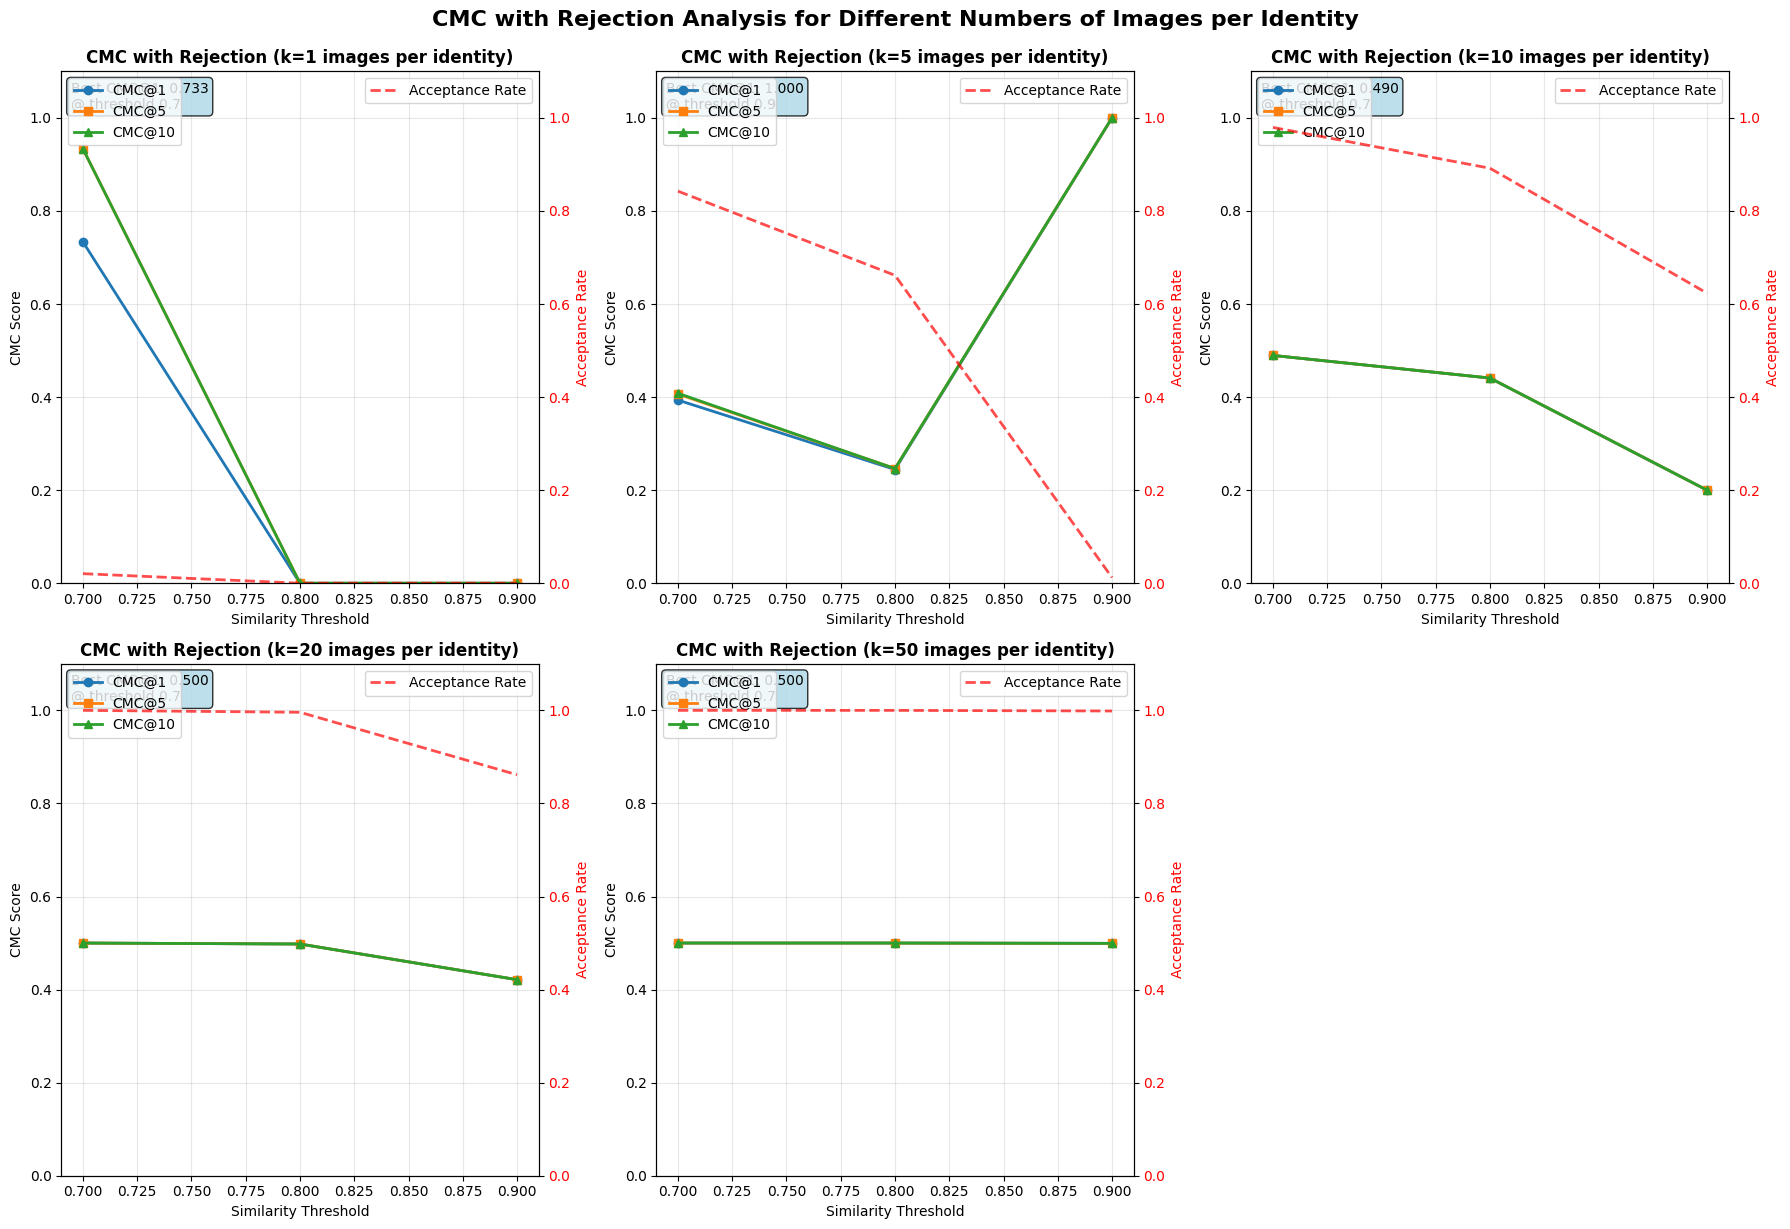

In [23]:
import numpy as np

import matplotlib.pyplot as plt

# Create plots for each k value in all_results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

k_vals = sorted(all_results.keys())
thresholds = [0.7, 0.8, 0.9]
cmc_k_values = [1, 5, 10]

for idx, k_val in enumerate(k_vals):
    if idx >= 6:  # Only plot first 6 k values if more exist
        break
        
    ax = axes[idx]
    
    # Extract data for this k value
    cmc_1_scores = []
    cmc_5_scores = []
    cmc_10_scores = []
    acceptance_rates = []
    
    for threshold in thresholds:
        if threshold in all_results[k_val]:
            cmc_1_scores.append(all_results[k_val][threshold][1]['CMC@1'])
            cmc_5_scores.append(all_results[k_val][threshold][5]['CMC@5'])
            cmc_10_scores.append(all_results[k_val][threshold][10]['CMC@10'])
            acceptance_rates.append(all_results[k_val][threshold][1]['acceptance_rate'])
    
    # Plot CMC curves
    ax.plot(thresholds, cmc_1_scores, 'o-', label='CMC@1', linewidth=2, markersize=6)
    ax.plot(thresholds, cmc_5_scores, 's-', label='CMC@5', linewidth=2, markersize=6)
    ax.plot(thresholds, cmc_10_scores, '^-', label='CMC@10', linewidth=2, markersize=6)
    
    # Add acceptance rate as secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(thresholds, acceptance_rates, 'r--', label='Acceptance Rate', linewidth=2, alpha=0.7)
    ax2.set_ylabel('Acceptance Rate', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 1.1)
    
    # Formatting
    ax.set_title(f'CMC with Rejection (k={k_val} images per identity)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Similarity Threshold')
    ax.set_ylabel('CMC Score')
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Add text with key statistics
    best_cmc1_idx = np.argmax(cmc_1_scores)
    best_threshold = thresholds[best_cmc1_idx]
    best_cmc1 = cmc_1_scores[best_cmc1_idx]
    
    ax.text(0.02, 0.98, f'Best CMC@1: {best_cmc1:.3f}\n@ threshold {best_threshold}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Hide unused subplots if any
for idx in range(len(k_vals), 6):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('CMC with Rejection Analysis for Different Numbers of Images per Identity', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [46]:
acc.append(compute_acc(11))  # Compute for k=10 as well

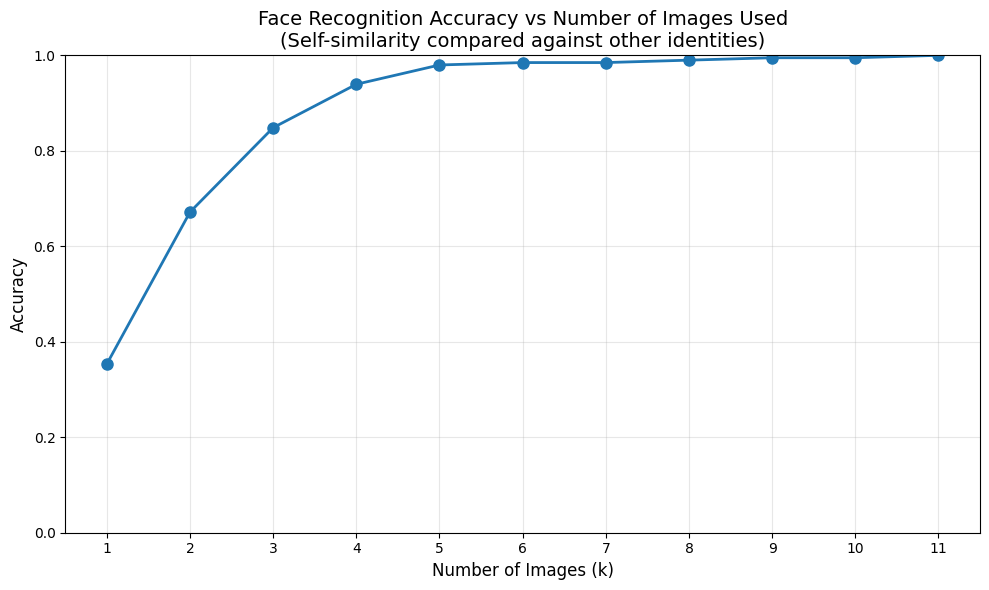

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 12), acc, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Images (k)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Face Recognition Accuracy vs Number of Images Used\n(Self-similarity compared against other identities)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 12))
plt.ylim(0, 1)

# Add description text
"""plt.text(0.02, 0.98, 
         'This plot shows how face recognition accuracy improves\nwith the number of images used per identity.\nHigher k means more images averaged for each person.',
         transform=plt.gca().transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))"""

plt.tight_layout()
plt.show()

In [51]:
import torch
from pathlib import Path

identities_folder = Path('/home/pablo/Desktop/reID/face_reID/identities')
loaded_identities = {}

for tensor_file in identities_folder.glob('*.pt'):
    person_name = tensor_file.stem  # Gets filename without .pt extension
    tensors = torch.load(tensor_file, map_location=device)
    loaded_identities[person_name] = tensors
    print(f"Loaded {person_name}: {len(tensors)} tensors")

print(f"\nTotal identities loaded: {len(loaded_identities)}")

Loaded Person88: 512 tensors
Loaded Person23: 512 tensors
Loaded Person86: 512 tensors
Loaded Person22: 512 tensors
Loaded Person78: 512 tensors
Loaded Person50: 512 tensors
Loaded Person11: 512 tensors
Loaded Person62: 512 tensors
Loaded Person21: 512 tensors
Loaded Person34: 512 tensors
Loaded Person13: 512 tensors
Loaded Person99: 512 tensors
Loaded Person51: 512 tensors
Loaded Person68: 512 tensors
Loaded Person98: 512 tensors
Loaded Person47: 512 tensors
Loaded Person12: 512 tensors
Loaded Person5: 512 tensors
Loaded Person29: 512 tensors
Loaded Person37: 512 tensors
Loaded Person54: 512 tensors
Loaded Person57: 512 tensors
Loaded Person66: 512 tensors
Loaded Person79: 512 tensors
Loaded Person81: 512 tensors
Loaded Person31: 512 tensors
Loaded Person41: 512 tensors
Loaded Person77: 512 tensors
Loaded Person71: 512 tensors
Loaded Person69: 512 tensors
Loaded Person87: 512 tensors
Loaded Person94: 512 tensors
Loaded Person30: 512 tensors
Loaded Person65: 512 tensors
Loaded Person53

In [55]:
total_avg_similarity = 0
num_people = len(loaded_identities)
all_similarities = []

for person_name, person_tensor in loaded_identities.items():
    similarities_with_others = []
    
    # Compare with all other people
    for other_name, other_tensor in loaded_identities.items():
        if person_name != other_name:  # Skip self-comparison
            similarity = F.cosine_similarity(person_tensor.unsqueeze(0), other_tensor.unsqueeze(0)).item()
            similarities_with_others.append(similarity)
            all_similarities.append(similarity)
    
    # Calculate average similarity for this person
    avg_similarity = sum(similarities_with_others) / len(similarities_with_others)
    total_avg_similarity += avg_similarity
    
    print(f"{person_name}: Average similarity with others = {avg_similarity:.4f}")

# Calculate overall average and median
overall_avg_similarity = total_avg_similarity / num_people
min_similarity = min(all_similarities)
max_similarity = max(all_similarities)
median_similarity = np.median(all_similarities)

print(f"\nOverall average similarity between different people: {overall_avg_similarity:.4f}")
print(f"Median similarity: {median_similarity:.4f}")
print(f"Minimum similarity: {min_similarity:.4f}")
print(f"Maximum similarity: {max_similarity:.4f}")

Person88: Average similarity with others = 0.2539
Person23: Average similarity with others = 0.2829
Person86: Average similarity with others = 0.2666
Person22: Average similarity with others = 0.2045
Person78: Average similarity with others = 0.2824
Person50: Average similarity with others = 0.1142
Person11: Average similarity with others = 0.0703
Person62: Average similarity with others = 0.2208
Person21: Average similarity with others = 0.1967
Person34: Average similarity with others = 0.2990
Person13: Average similarity with others = 0.1649
Person99: Average similarity with others = 0.1579
Person51: Average similarity with others = 0.2867
Person68: Average similarity with others = 0.2506
Person98: Average similarity with others = 0.2818
Person47: Average similarity with others = 0.2706
Person12: Average similarity with others = 0.2476
Person5: Average similarity with others = 0.0251
Person29: Average similarity with others = 0.0894
Person37: Average similarity with others = 0.1960
P

In [57]:
embs = compute_ids(20)

# Compute all self-similarities for each person
self_similarities = {}

for person_name, person_data in embs.items():
    first_tensor = person_data['first_tensor']
    second_tensor = person_data['second_tensor']
    
    self_similarity = F.cosine_similarity(first_tensor.unsqueeze(0), second_tensor.unsqueeze(0)).item()
    self_similarities[person_name] = self_similarity
    
    print(f"{person_name}: Self-similarity = {self_similarity:.4f}")

# Calculate statistics
all_self_sims = list(self_similarities.values())
avg_self_similarity = np.mean(all_self_sims)
min_self_similarity = min(all_self_sims)
max_self_similarity = max(all_self_sims)
median_self_similarity = np.median(all_self_sims)

print(f"\nSelf-similarity statistics:")
print(f"Average: {avg_self_similarity:.4f}")
print(f"Median: {median_self_similarity:.4f}")
print(f"Minimum: {min_self_similarity:.4f}")
print(f"Maximum: {max_self_similarity:.4f}")

n000300: Self-similarity = 0.9549
n000301: Self-similarity = 0.9236
n000302: Self-similarity = 0.9504
n000303: Self-similarity = 0.7793
n000304: Self-similarity = 0.8827
n000305: Self-similarity = 0.9233
n000306: Self-similarity = 0.9342
n000307: Self-similarity = 0.9153
n000308: Self-similarity = 0.9641
n000309: Self-similarity = 0.8954
n000310: Self-similarity = 0.8631
n000311: Self-similarity = 0.9614
n000312: Self-similarity = 0.8588
n000313: Self-similarity = 0.9418
n000314: Self-similarity = 0.9766
n000315: Self-similarity = 0.9328
n000316: Self-similarity = 0.9726
n000317: Self-similarity = 0.9344
n000318: Self-similarity = 0.9648
n000319: Self-similarity = 0.9471
n000320: Self-similarity = 0.7794
n000321: Self-similarity = 0.9035
n000322: Self-similarity = 0.9502
n000323: Self-similarity = 0.9034
n000324: Self-similarity = 0.9417
n000325: Self-similarity = 0.9234
n000326: Self-similarity = 0.9473
n000327: Self-similarity = 0.9488
n000328: Self-similarity = 0.8991
n000329: Self-

Number of positive pairs: 99
Number of negative pairs: 9702
ROC AUC: 1.0000


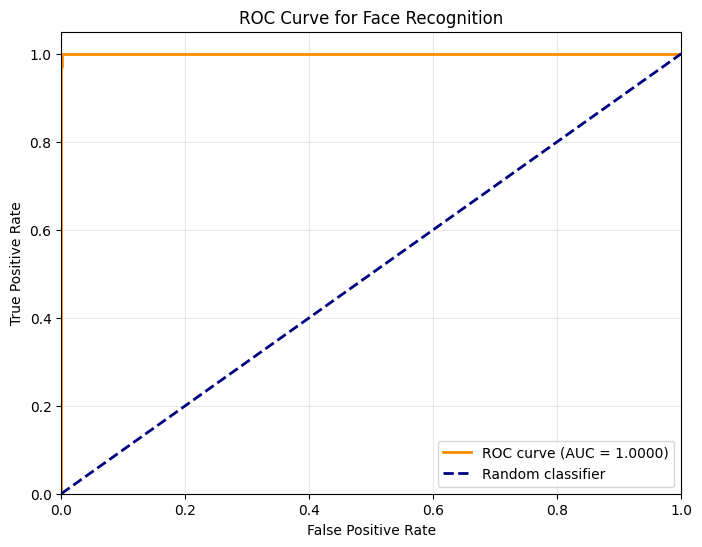

In [ ]:
identities_folder = Path('/home/pablo/Desktop/reID/face_reID/identities')
loaded_identities = {}

for tensor_file in identities_folder.glob('*.pt'):
    person_name = tensor_file.stem  # Gets filename without .pt extension
    tensors = torch.load(tensor_file, map_location=device)
    loaded_identities[person_name] = tensors

In [ ]:
identities_folder = Path('/home/pablo/Desktop/reID/face_reID/identities')
loaded_identities = {}

# Check if folder exists
if identities_folder.exists():
    # Look for folders containing tensor files
    for folder in identities_folder.iterdir():
        if folder.is_dir():
            tensor1_path = folder / 'tensor1.pt'
            tensor2_path = folder / 'tensor2.pt'
            
            if tensor1_path.exists() and tensor2_path.exists():
                tensor1 = torch.load(tensor1_path, map_location=device)
                tensor2 = torch.load(tensor2_path, map_location=device)
                loaded_identities[folder.name] = {
                    'tensor1': tensor1,
                    'tensor2': tensor2
                }
                print(f"Loaded identity {folder.name}: tensor1 shape {tensor1.shape}, tensor2 shape {tensor2.shape}")
    
    print(f"\nTotal identities loaded: {len(loaded_identities)}")
    print(f"Available identities: {list(loaded_identities.keys())}")
else:
    print("Identities folder not found!")